In [1]:
import xml.etree.ElementTree as ET
import sys
sys.path.append('../')

from ultralytics.utils.downloads import download
from tqdm import tqdm
from pathlib import Path
from tqdm import tqdm
import glob



#TODO create a Pascal-OSCD yaml and change the code to have remove labeling correct

#### https://docs.ultralytics.com/fr/datasets/detect/voc/#dataset-yaml

In [2]:
import os

paths = ['VOC',
         'VOC/support',
         'VOC/support/images']

for path in paths:
    if not os.path.exists(path):
        os.mkdir(path)


# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path = 'VOC'
train = [ # train images (relative to 'path')  16551 images
  'images/train2012',
  'images/train2007',
  'images/val2012',
  'images/val2007'
]
val = [ # val images (relative to 'path')  4952 images
  'images/test2007'
]
test = [ # test images (optional)
  'images/test2007'
]

In [3]:
dir = Path(path)  # dataset root dir

In [4]:
url = 'https://github.com/ultralytics/yolov5/releases/download/v1.0/'
urls = [f'{url}VOCtrainval_06-Nov-2007.zip',  # 446MB, 5012 images
          f'{url}VOCtest_06-Nov-2007.zip',  # 438MB, 4953 images
          f'{url}VOCtrainval_11-May-2012.zip']  # 1.95GB, 17126 images
download(urls, dir=dir / 'images', curl=True, threads=3)

WARNING ⚠️ Skipping VOC/images/VOCtrainval_06-Nov-2007.zip unzip as destination directory VOC/images/VOCdevkit is not empty.
WARNING ⚠️ Skipping VOC/images/VOCtrainval_11-May-2012.zip unzip as destination directory VOC/images/VOCdevkit is not empty.


In [9]:
# Classes


def convert_box(size, box):
    dw, dh = 1. / size[0], 1. / size[1]
    x, y, w, h = (box[0] + box[1]) / 2.0 - 1, (box[2] + box[3]) / 2.0 - 1, box[1] - box[0], box[3] - box[2]
    return x * dw, y * dh, w * dw, h * dh

names = {
    0: 'aeroplane',
    1: 'bicycle',
    2: 'bird',
    3: 'boat',
    4: 'bottle',
    5: 'bus',
    6: 'car',
    7: 'cat',
    8: 'chair',
    9: 'cow',
    10: 'diningtable',
    11: 'dog',
    12: 'horse',
    13: 'motorbike',
    14: 'person',
    15: 'pottedplant',
    16: 'sheep',
    17: 'sofa',
    18: 'train',
    19: 'tvmonitor',
}

def convert_label(path, lb_path, year, image_id):

    in_file = open(path / f'VOC{year}/Annotations/{image_id}.xml')
    out_file = open(lb_path, 'w')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    name = list(names.values())  # names list
    for obj in root.iter('object'):
        cls = obj.find('name').text
        if cls in name and int(obj.find('difficult').text) != 1:
            xmlbox = obj.find('bndbox')
            bb = convert_box((w, h), [float(xmlbox.find(x).text) for x in ('xmin', 'xmax', 'ymin', 'ymax')])
            cls_id = name.index(cls)  # class id
            out_file.write(" ".join(str(a) for a in (cls_id, *bb)) + '\n')

In [10]:
# Convert
path = dir / 'images/VOCdevkit'
print(path)
for year, image_set in ('2012', 'train'), ('2012', 'val'), ('2007', 'train'), ('2007', 'val'), ('2007', 'test'):
    imgs_path = dir / 'images' / f'{image_set}{year}'
    lbs_path = dir / 'labels' / f'{image_set}{year}'
    imgs_path.mkdir(exist_ok=True, parents=True)
    lbs_path.mkdir(exist_ok=True, parents=True)

    with open(path / f'VOC{year}/ImageSets/Main/{image_set}.txt') as f:
        image_ids = f.read().strip().split()
    for id in tqdm(image_ids, desc=f'{image_set}{year}'):
        f = path / f'VOC{year}/JPEGImages/{id}.jpg'  # old img path
        #if os.path.exists(f): #TODO ADD THIS
        lb_path = (lbs_path / f.name).with_suffix('.txt')  # new label path
        f.rename(imgs_path / f.name)  # move image
        convert_label(path, lb_path, year, id)  # convert labels to YOLO format

VOC/images/VOCdevkit


test2007: 100%|██████████| 4952/4952 [00:01<00:00, 2864.55it/s]


In [12]:
path = 'VOC'
path2 = '../../datasets/VOC'

a = glob.glob(path+'/images/train2012/*')
b = glob.glob(path2+'/images/train2012/*')

a = [i.split("/")[-1] for i in a]
b = [i.split("/")[-1] for i in b]
print(a)
print(b)

print(len(a))
print(len(b))
difference = list(set(a) - set(b))
print(difference)
print(len(difference))


# #BUG test2007/000001.jpg + annotation
# # train2012/000008.jpg

['2008_000008.jpg', '2008_000015.jpg', '2008_000019.jpg', '2008_000023.jpg', '2008_000028.jpg', '2008_000033.jpg', '2008_000036.jpg', '2008_000037.jpg', '2008_000041.jpg', '2008_000045.jpg', '2008_000053.jpg', '2008_000060.jpg', '2008_000066.jpg', '2008_000070.jpg', '2008_000074.jpg', '2008_000085.jpg', '2008_000089.jpg', '2008_000093.jpg', '2008_000095.jpg', '2008_000096.jpg', '2008_000097.jpg', '2008_000099.jpg', '2008_000103.jpg', '2008_000105.jpg', '2008_000109.jpg', '2008_000112.jpg', '2008_000128.jpg', '2008_000131.jpg', '2008_000132.jpg', '2008_000141.jpg', '2008_000142.jpg', '2008_000143.jpg', '2008_000144.jpg', '2008_000148.jpg', '2008_000151.jpg', '2008_000154.jpg', '2008_000162.jpg', '2008_000176.jpg', '2008_000181.jpg', '2008_000185.jpg', '2008_000187.jpg', '2008_000188.jpg', '2008_000189.jpg', '2008_000191.jpg', '2008_000192.jpg', '2008_000193.jpg', '2008_000196.jpg', '2008_000197.jpg', '2008_000199.jpg', '2008_000202.jpg', '2008_000207.jpg', '2008_000217.jpg', '2008_00022

In [ ]:
# #TODO add copie coller ^^

# # Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
# train: # train images (relative to 'path')  16551 images
#   - images/train2012
#   - images/train2007
#   - images/val2012
#   - images/val2007
# val: # val images (relative to 'path')  4952 images
#   - images/test2007
# test: # test images (optional)
#   - images/test2007

# # Classes
# names:
#   0: aeroplane
#   1: bicycle
#   2: bird
#   3: boat
#   4: bottle
#   5: bus
#   6: car
#   7: cat
#   8: chair
#   9: cow
#   10: diningtable
#   11: dog
#   12: horse
#   13: motorbike
#   14: person
#   15: pottedplant
#   16: sheep
#   17: sofa
#   18: train
#   19: tvmonitor
        

#### https://drive.google.com/file/d/1nl9-DEpBBJ5w6hxVdijY6hFxoQdz8aso/view
DANA 

In [31]:
# novel = ['cow, sheep, cat, aero']

novel = [9, 16, 7, 0]

for year, image_set in ('2012', 'train'), ('2007', 'train'), ('2012', 'val'), ('2007', 'val'):
    imgs_path = dir / 'images' / f'{image_set}{year}/*'
    lbs_path = dir / 'labels' / f'{image_set}{year}/*'

    for i in tqdm(glob.glob(str(lbs_path))):
        a = []
        with open(i,'+r') as f:
            info = f.read().strip().split()
            size = len(info)
            for y in range(0,size,5):
                inf = info[y:y+5]
                if not int(inf[0]) in novel:
                    a.append([z for z in inf])
        if len(a) != int(size/5):
            with open(i,'+w') as f:
                for y in a:
                    c = ' '.join(y)+'\n'
                    f.write(str(c))                



  0%|          | 0/2501 [00:00<?, ?it/s]

100%|██████████| 2510/2510 [00:00<00:00, 24514.73it/s]


  0%|          | 0/2501 [00:00<?, ?it/s]

100%|██████████| 2510/2510 [00:00<00:00, 31448.70it/s]


20


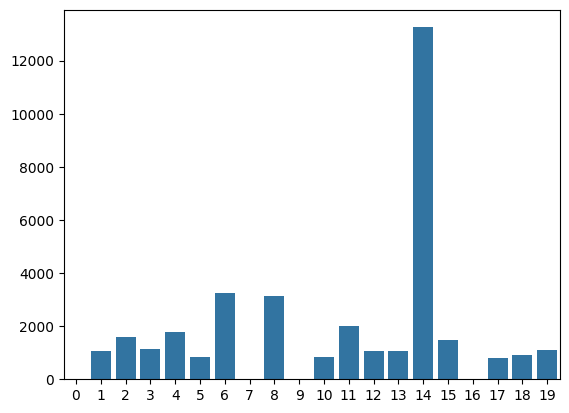

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

a = []

for year, image_set in ('2012', 'train'), ('2007', 'train'), ('2012', 'val'), ('2007', 'val'):
    lbs_path = dir / 'labels' / f'{image_set}{year}/*'

    for i in tqdm(glob.glob(str(lbs_path))):
        with open(i,'+r') as f:
            info = f.read().strip().split()
            size = len(info)
            for y in range(0,size,5):
                inf = info[y:y+5]
                a.append(inf[0])   

count = {i:a.count(str(i)) for i in range(0,20)}
print(len(count))

plt.figure()
sns.barplot(x=range(0,20),y=count.values())
plt.show()

  0%|          | 0/4952 [00:00<?, ?it/s]

100%|██████████| 4952/4952 [00:00<00:00, 31033.78it/s]


20


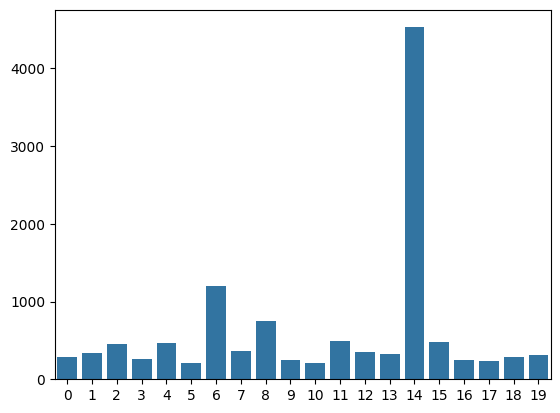

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

a = []

for year, image_set in ('2007', 'test'),:
    lbs_path = dir / 'labels' / f'{image_set}{year}/*'

    for i in tqdm(glob.glob(str(lbs_path))):
        with open(i,'+r') as f:
            info = f.read().strip().split()
            size = len(info)
            for y in range(0,size,5):
                inf = info[y:y+5]
                a.append(inf[0])   

count = {i:a.count(str(i)) for i in range(0,20)}
print(len(count))

plt.figure()
sns.barplot(x=range(0,20),y=count.values())
plt.show()

In [61]:
import os
import shutil

dir = Path("VOC")

novel = [9, 16, 7, 0]

images_novel_path = "VOC/images/test2007novel/"
# images_base_path = "VOC/images/test2007base/"
labels_novel_path = "VOC/labels/test2007novel/"
# labels_base_path = "VOC/labels/test2007base/"

paths = ['VOC',
         'VOC/images/test2007novel',
        #  'VOC/images/test2007base',
         'VOC/labels/test2007novel']
        #  'VOC/labels/test2007base']

for path in paths:
    if not os.path.exists(path):
        os.mkdir(path)

for year, image_set in ('2007', 'test'),:
    imgs_path = dir / 'images' / f'{image_set}{year}'
    lbs_path = dir / 'labels' / f'{image_set}{year}/*'

    for i in tqdm(glob.glob(str(lbs_path))):
        a = []
        b = []
        with open(i,'+r') as f:
            info = f.read().strip().split()
            size = len(info)
            for y in range(0,size,5):
                inf = info[y:y+5]
                if int(inf[0]) in novel:
                    a.append([z for z in inf])
                # else:
                #     b.append([z for z in inf])
        if len(a) != 0:
            with open(labels_novel_path+i.split('/')[-1],'+w') as f:
                for y in a:
                    c = ' '.join(y)+'\n'
                    f.write(str(c))   
            shutil.copy("VOC/images/test2007/"+i.split('/')[-1][:-3]+'jpg', "VOC/images/test2007novel/"+i.split('/')[-1][:-3]+'jpg',)
        # if len(b) != 0:
        #     with open(labels_base_path+i.split('/')[-1],'+w') as f:
        #         for y in b:
        #             c = ' '.join(y)+'\n'
        #             f.write(str(c))   
        #     shutil.copy("VOC/images/test2007/"+i.split('/')[-1][:-3]+'jpg', "VOC/images/test2007base/"+i.split('/')[-1][:-3]+'jpg',)
 

  0%|          | 0/4952 [00:00<?, ?it/s]

100%|██████████| 4952/4952 [00:01<00:00, 3324.55it/s]


In [65]:
from PIL import Image, ImageOps

def resize_with_padding(img, expected_size):
    width, height = img.size
    ratio = width / height
    if width < height:
        img = img.resize((int(ratio*expected_size[0]),int(expected_size[0])))
    else:
        img = img.resize((int(expected_size[1]),int((1/ratio)*expected_size[1])))
        
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

liste = glob.glob('VOC/support/images/*')
print(liste)

for i in liste:
    image = Image.open(i)
    image = resize_with_padding(image, (640,640))
    image.save(i)


['VOC/support/images/0.png', 'VOC/support/images/1.png', 'VOC/support/images/2.png', 'VOC/support/images/3.png', 'VOC/support/images/4.png', 'VOC/support/images/5.png', 'VOC/support/images/6.png', 'VOC/support/images/7.png', 'VOC/support/images/8.png', 'VOC/support/images/9.png', 'VOC/support/images/10.png', 'VOC/support/images/11.png', 'VOC/support/images/12.png', 'VOC/support/images/13.png', 'VOC/support/images/14.png', 'VOC/support/images/15.png', 'VOC/support/images/16.png', 'VOC/support/images/18.png', 'VOC/support/images/19.png', 'VOC/support/images/17.png']
